### Image processing and inferencing

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from PIL import Image
import os
import albumentations as A
import random

/Users/cistusai/Desktop/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cistusai/Desktop/.venv/lib/python3.11/site-packages/albumentations/check_version.py:147: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1006)>
  data = fetch_version_info()


In [47]:
def distort_image(image, noise_strength=0):
    """
    Apply Albumentations pipeline with Gaussian noise, Multiplicative noise,
    Distortion, and Cutout. 
    noise_strength = 0 -> return original image
    noise_strength = 1..3 -> increasing augmentation harshness
    """
    if noise_strength == 0:
        return np.array(image)

    # Scale augmentation parameters with noise_strength
    gaussian_var_limit = (noise_strength*0.05, noise_strength*0.05)
    cutout_h_w_range_val = 10 * noise_strength
    cutout_h_w_range = [cutout_h_w_range_val, cutout_h_w_range_val]

    # Albumentations transformations
    
    gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True,p=1)

    # Choose cutout fill value at random
    cutout_fill_value = random.choice(["random_uniform", "random"])
    number_of_cutout_areas_range = [noise_strength, noise_strength]

    print(f"cutout_fill_value : {cutout_fill_value}")
    
    cutout = A.CoarseDropout(
        num_holes_range = number_of_cutout_areas_range,
        hole_height_range = cutout_h_w_range,
        hole_width_range = cutout_h_w_range,
        fill=cutout_fill_value,
        p=1
    )

    color_jitter = A.ColorJitter(
        brightness=0.1 * noise_strength,
        contrast=0.1 * noise_strength,
        saturation=0.1 * noise_strength,
        hue=0.08 * noise_strength,
        p=1
    )

    # Albumentations pipeline
    transform = A.Compose([
        color_jitter,
        gaussian_noise,
        cutout,
    ])

    # Apply to image
    image_np = np.array(image)
    augmented = transform(image=image_np)
    return augmented["image"]


In [48]:
import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt

def display_distorted_images(url):
    """
    Downloads an image from a URL, applies distortions with noise strengths 0..3,
    and displays the results in a grid.
    """
    # Download image
    response = requests.get(url)
    response.raise_for_status()  # raise error if download fails
    image = Image.open(BytesIO(response.content)).convert("RGB")
    
    # Apply distort_image with strengths 0..3
    results = [distort_image(image, noise_strength=i) for i in range(4)]
    
    # Display results in grid
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for i, ax in enumerate(axes):
        ax.imshow(results[i])
        ax.set_title(f"Noise Strength {i}")
        ax.axis("off")
    
    plt.tight_layout()
    plt.show()

cutout_fill_value : random
cutout_fill_value : random
cutout_fill_value : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_27915/1909160913.py:18: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True,p=1)


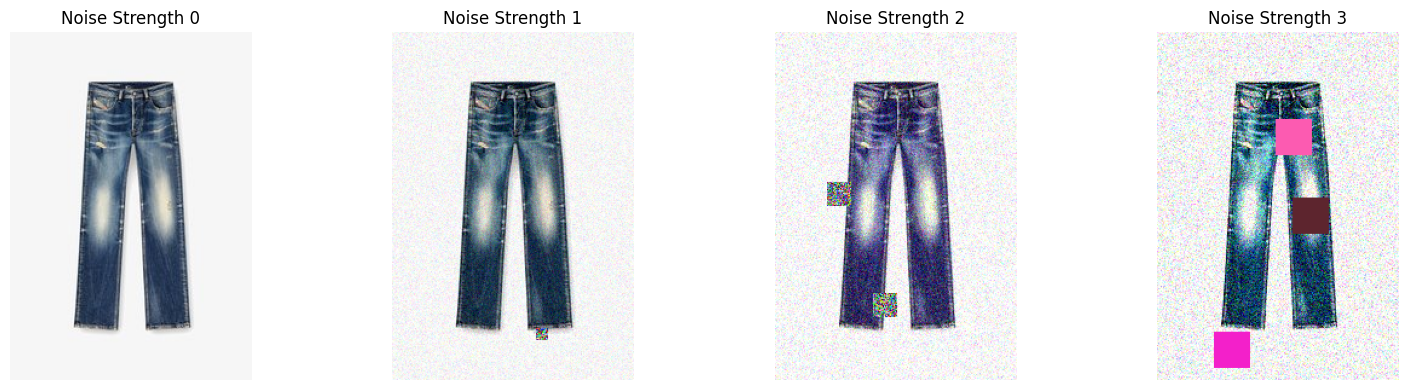

In [49]:
test_url = "https://img01.ztat.net/article/spp-media-p1/0dff5c8b79394f748b0f5f59558d0d2e/7cbaa9bff2ab4ac98a7bea4070ac80b7.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

cutout_fill_value : random
cutout_fill_value : random
cutout_fill_value : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_27915/1909160913.py:18: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True,p=1)


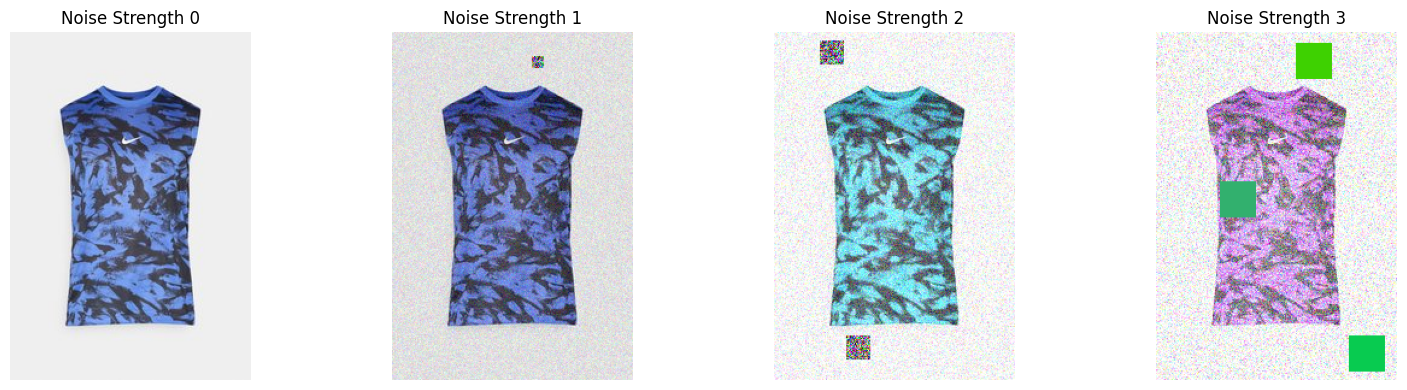

In [50]:
test_url = "https://img01.ztat.net/article/spp-media-p1/21d0fe1b996b442289f5eabde941ede6/70e435a260f3460392e34fff5feb3e8a.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

cutout_fill_value : random
cutout_fill_value : random_uniform
cutout_fill_value : random_uniform


/var/folders/sl/w6lsbdv11kg3v379x11s87_h0000gq/T/ipykernel_27915/1909160913.py:18: UserWarning: Argument(s) 'mean' are not valid for transform GaussNoise
  gaussian_noise = A.GaussNoise(gaussian_var_limit, mean=0, per_channel=True,p=1)


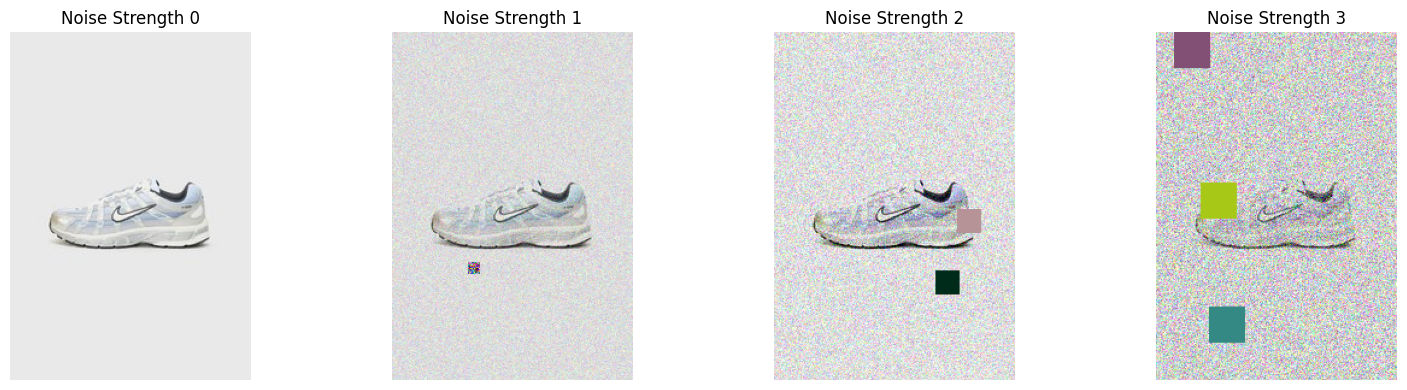

In [51]:
test_url = "https://img01.ztat.net/article/spp-media-p1/77ee1ce7e402424db0c58512165b72ac/b3d0aacaa2204decb31fecda85c54f71.jpg?imwidth=156&filter=packshot"
display_distorted_images(test_url)

In [7]:
IMAGE_FOLDER = "path/to/images/"            # Folder where the images of garment/shoes are stored
OUTPUT_FOLDER = "path/to/save/latents/"     # Folder to save latent space .npy files

In [8]:
def process_images(image_folder=IMAGE_FOLDER, 
                   output_folder=OUTPUT_FOLDER,
                   dino_v2_infra=None):
    """
    Process images in a folder, apply transformations with different noise strengths,
    run model inference, and save latent spaces as .npy files.
    """
    # Ensure output folder exists
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    if dino_v2_infra is None:
        raise ValueError("Please provide a DinoDeployment object.")

    # Loop over all image files in the folder
    for image_path in Path(image_folder).glob("*"):
        if not image_path.is_file():
            continue

        image_name = image_path.name  # filename with extension

        # Read image
        image = Image.open(image_path)

        # Run for 4 different transform strengths
        for noise_strength in range(4):
            # Distort image with given strength
            distorted_image = distort_image(image, noise_strength=noise_strength)

            # Model inference
            latent_space = dino_v2_infra.run_inference(distorted_image)

            # Save latent space with prefix
            output_path = Path(output_folder) / f"{image_name}_{noise_strength}_latent_space.npy"
            np.save(output_path, latent_space)

### Latent space explorations - robustness of the model